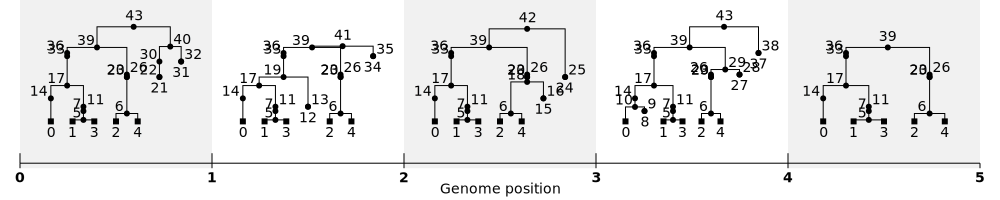

In [1]:
# Packages
import gene_model
import gfs
import color_scheme

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

import msprime
import tskit
import numpy as np
from typing import List, Union
from multiprocessing import Pool
import warnings
from random import randint

import hgt_simulation
import hgt_mutations
import hgt_sim_args
from gfs import gfs_from_matrix

from typing import List, Any
from msprime import _msprime
import functools
import dataclasses

from random import randint


alleles = ["absent", "present"]

# Parameters:

theta=1
rho=0
gene_conversion_rate=0
recombination_rate=0
hgt_rate=0.5
num_samples=5
num_sites=5
double_site_relocation=False


# Start:

args = hgt_sim_args.Args(
    sample_size=num_samples,
    num_sites=num_sites,
    gene_conversion_rate=0,
    recombination_rate=0,
    hgt_rate=hgt_rate,
    ce_from_ts=None,
    ce_from_nwk=None,
    random_seed=randint(1, int(2**32 - 2)),
)
theta = theta * 2
rho = rho * 2

ts, hgt_edges = hgt_simulation.run_simulate(args)

theta_total_events = theta
rho_total_events = rho * num_sites

root_proba = theta_total_events / (rho_total_events if rho_total_events != 0 else theta)
if not (0 <= root_proba <= 1):
    raise ValueError(f"Invalid theta / rho resulting in a root probability of {root_proba}")

event_rate = rho_total_events + theta_total_events
theta_proba = theta_total_events / event_rate
rho_proba = rho_total_events / event_rate
event_rate /= num_sites

gain_loss_model = msprime.MatrixMutationModel(
    alleles,
    root_distribution=[1, 0],
    transition_matrix=[
        [1 - theta_proba, theta_proba],
        [rho_proba, 1 - rho_proba],
    ],
)

tables = ts.dump_tables()

# Set the ancestral state for each site.
poisson = np.random.poisson(theta / (rho if rho != 0 else 1))
poisson = min(poisson, num_sites)
poisson = num_sites

position = np.arange(0, num_sites, dtype="uint32")
position = np.random.choice(position, poisson, replace=False)
position.sort()

ancestral_state = [alleles[0]] * poisson
ancestral_state, ancestral_state_offset = tskit.pack_strings(ancestral_state)

tables.sites.set_columns(
    position=position,
    ancestral_state=ancestral_state,
    ancestral_state_offset=ancestral_state_offset,
)
ts = tables.tree_sequence()

ts_backup = ts

ts.draw_svg()

╔══╤════╤════╤══════════╤═════════════╤══════╤════════╗
║id│site│node│time      │derived_state│parent│metadata║
╠══╪════╪════╪══════════╪═════════════╪══════╪════════╣
║0 │   0│  26│0.76002975│      present│    -1│ b'\x00'║
║1 │   0│   0│0.00000000│       absent│    -1│ b'\x01'║
║2 │   0│   1│0.00000000│       absent│    -1│ b'\x01'║
║3 │   0│   2│0.00000000│      present│     0│ b'\x01'║
║4 │   0│   3│0.00000000│       absent│    -1│ b'\x01'║
║5 │   0│   4│0.00000000│      present│     0│ b'\x01'║
║6 │   1│  13│0.25117879│      present│    -1│ b'\x00'║
║7 │   1│   0│0.00000000│       absent│    -1│ b'\x01'║
║8 │   1│   1│0.00000000│      present│     6│ b'\x01'║
║9 │   1│   2│0.00000000│       absent│    -1│ b'\x01'║
║10│   1│   3│0.00000000│      present│     6│ b'\x01'║
║11│   1│   4│0.00000000│       absent│    -1│ b'\x01'║
║12│   2│  16│0.38815698│      present│    -1│ b'\x00'║
║13│   2│   0│0.00000000│      present│    12│ b'\x01'║
║14│   2│   1│0.00000000│       absent│    -1│ b

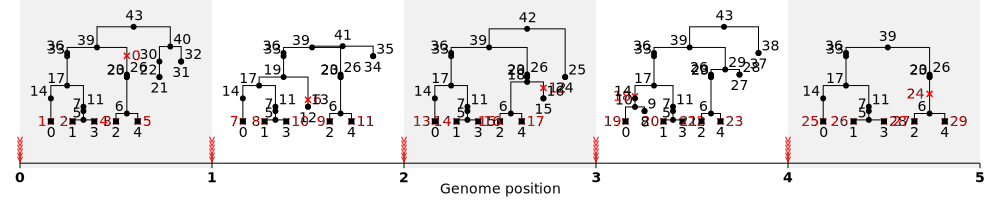

In [5]:
ts = ts_backup

edges_to_remove = []
sites = {}

# Sim_mutations:

tables = ts.dump_tables()

gene_count = tables.sequence_length

gain_loss_model = hgt_mutations.PythonMutationMatrixModel(
    alleles=gain_loss_model.alleles,
    root_distribution=gain_loss_model.root_distribution,
    transition_matrix=gain_loss_model.transition_matrix,
)
model = gain_loss_model

rate_map = msprime.RateMap(position=[0, gene_count], rate=[event_rate])

edges = list(tables.edges)
edges.extend(hgt_edges)

child_ids = {e.child for e in edges}
root_nodes = list({e.parent for e in edges if e.parent not in child_ids})

hgt_generator = hgt_mutations.HGTMutationGenerator(rate_map=rate_map, model=gain_loss_model)

seed = randint(0, 4294967295)
one_mutation = True
keep=True
discrete_genome=True


rng = _msprime.RandomGenerator(seed)
if keep:
    initialise_sites(tables)

tables.sites.clear()
tables.mutations.clear()
if one_mutation:
    place_one_mutation(tables, edges, discrete_genome=discrete_genome)
else:
    place_mutations(tables, edges, discrete_genome=discrete_genome)

apply_mutations(tables, edges, root_nodes)


populate_tables(tables)
print(tables.mutations)

edges_repaired = rectify_hgt_edges(tables, edges)
tables.edges.clear()

for e in edges_repaired:
    tables.edges.add_row(left=e.left, right=e.right, parent=e.parent, child=e.child)
ts = tables.tree_sequence()

for var in ts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

print(ts.draw_text())  
ts.draw_svg()



In [229]:
def follow_edge(bp, node, edges, tree_parent):
    child_edges = [e for e in edges if e.parent == node if e.left <= bp[0] and bp[1] <= e.right]
    #print(child_edges)
    for e in child_edges:
        is_hgt = bool(int.from_bytes(e.metadata) & bin_hgt_mask)
        if not tree_parent[bp][e.child]:
            tree_parent[bp][e.child] = {(e.parent, is_hgt)}
        elif (e.parent, False) in tree_parent[bp][e.child] and is_hgt:
            # Is hgt, but not added as parent yet, overwriting the old (non hgt) entry
            tree_parent[bp][e.child].remove((e.parent, False))
            tree_parent[bp][e.child].add((e.parent, True))
        else:
            tree_parent[bp][e.child].add((e.parent, is_hgt))
        
        follow_edge(bp, e.child, edges, tree_parent)



bp_left, bp_right = zip(*((e.left, e.right) for e in edges))
breakpoints = sorted(list(set(bp_left + bp_right)))
tree_parent = {}

for bp in zip(breakpoints, breakpoints[1:]):
    tree_parent[bp] = [set() for _ in range(tables.nodes.num_rows)]
    for root_node in root_nodes:
        # Index= Child ID, Value: Set of parents.
        follow_edge(bp, root_node, edges, tree_parent)

    root_node = max([e.parent for e in edges if e.left <= bp[0] and bp[1] <= e.right])
    follow_edge(bp, root_node, edges, tree_parent)
"""     
for pos, site in sites.items():
    assert pos == site.position
    # the responsible
    k = [k for k in tree_parent.keys() if k[0] <= pos <= k[1]][0]   ##### CHANGE!!!
    choose_alleles(tree_parent[k], site, None)
"""
tree_parent

{(0.0, 2.0): [{(12, False)},
  {(8, False)},
  {(8, False)},
  {(9, False)},
  {(5, False)},
  {(10, False)},
  set(),
  set(),
  {(9, False)},
  {(10, False)},
  {(12, False)},
  set(),
  set()],
 (2.0, 3.0): [{(11, False)},
  {(8, False)},
  {(8, False)},
  {(9, False)},
  {(5, False)},
  {(7, True), (10, False)},
  {(7, False)},
  {(11, False)},
  {(9, False)},
  {(10, False)},
  {(12, False)},
  {(12, False)},
  set()],
 (3.0, 5.0): [{(12, False)},
  {(8, False)},
  {(8, False)},
  {(9, False)},
  {(5, False)},
  {(10, False)},
  set(),
  set(),
  {(9, False)},
  {(10, False)},
  {(12, False)},
  set(),
  set()]}

In [2]:
bin_null_mask = 0b00
bin_sentinel_mask = 0b01
bin_hgt_mask = 0b10

def print_state(self):
    positions = sorted(sites.keys())
    for pos in positions:
        print(sites[pos])

def add_site(position, new, ancestral_state=None, metadata=b""):
    assert position not in sites
    site = hgt_mutations.Site(
        position=position,
        ancestral_state=ancestral_state,
        metadata=metadata,
        mutations=[],
        new=new,
    )
    sites[position] = site
    return site

def initialise_sites(tables):
    mutation_rows = iter(tables.mutations)
    mutation_row = next(mutation_rows, None)
    j = 0
    for site_id, site_row in enumerate(tables.sites):
        site = add_site(
            position=site_row.position,
            new=False,
            ancestral_state=site_row.ancestral_state,
            metadata=site_row.metadata,
        )
        while mutation_row is not None and mutation_row.site == site_id:
            site.add_mutation(
                node=mutation_row.node,
                time=mutation_row.time,
                new=False,
                derived_state=mutation_row.derived_state,
                metadata=mutation_row.metadata,
                id=j,
            )
            j += 1
            mutation_row = next(mutation_rows, None)

def populate_tables(tables):
    positions = sorted(sites.keys())
    site_id = 0
    for pos in positions:
        site = sites[pos]
        num_mutations = 0
        for mutation in site.mutations:
            if mutation.parent is None:
                parent_id = tskit.NULL
            else:
                parent_id = mutation.parent.id
                assert parent_id >= 0
            mutation_id = tables.mutations.add_row(
                site_id,
                mutation.node,
                mutation.derived_state,
                parent=parent_id,
                metadata=mutation.metadata,
                time=mutation.time,
            )
            assert mutation_id > parent_id
            mutation.id = mutation_id
            num_mutations += 1

        if (not site.new) or num_mutations > 0:
            sid = tables.sites.add_row(site.position, site.ancestral_state, site.metadata)
            assert sid == site_id
            site_id += 1

def place_mutations(tables, edges, discrete_genome=False):
    """
    edges: List of edges including hgt edges
    """
    # Insert a sentinel into the map for convenience.
    map_position = np.hstack([rate_map.position, [tables.sequence_length]])
    node_times = tables.nodes.time
    for edge in edges:
        branch_start = node_times[edge.child]
        branch_end = node_times[edge.parent]
        branch_length = branch_end - branch_start
        index = np.searchsorted(map_position, edge.left)
        if map_position[index] > edge.left:
            index -= 1
        left = edge.left
        right = 0
        while right != edge.right:
            right = min(edge.right, map_position[index + 1])
            site_left = np.ceil(left) if discrete_genome else left
            site_right = np.ceil(right) if discrete_genome else right
            assert site_left <= site_right
            assert map_position[index] <= left
            assert right <= map_position[index + 1]
            assert right <= edge.right
            # Generate the mutations.
            rate = rate_map.rate[index]
            mu = rate * (site_right - site_left) * branch_length
            for _ in range(rng.poisson(mu)[0]):
                position = rng.flat(site_left, site_right)[0]
                if discrete_genome:
                    position = np.floor(position)
                assert edge.left <= position
                assert position < edge.right
                if position not in sites:
                    add_site(position=position, new=True)
                site = sites[position]
                time = rng.flat(branch_start, branch_end)[0]
                site.add_mutation(
                    node=edge.child,
                    time=time,
                    new=True,
                    metadata=bin_null_mask.to_bytes(1),
                )
            index += 1
            left = right
    # Add a sentinel mutation at directly above the leafs
    leaf_node_ids = [i for i, f in enumerate(tables.nodes.flags) if f == 1]
    for pos, site in sites.items():
        for leaf in leaf_node_ids:
            site.add_mutation(
                node=leaf,
                time=0.00000000001,
                new=True,
                metadata=bin_sentinel_mask.to_bytes(1),
            )

def place_one_mutation(tables, edges, discrete_genome=False):
    """
    edges: List of edges including hgt edges
    """
    # Insert a sentinel into the map for convenience.
    map_position = np.hstack([rate_map.position, [tables.sequence_length]])
    node_times = tables.nodes.time
    
    for pos, site in sites.items():  # Iteriere über die Sites

        egdes_site = []
        for edge in edges:
            if (edge.left <= pos and edge.right >= pos + 1):
                egdes_site.append(edge)
        
        # Berechne die Wahrscheinlichkeiten basierend auf den Branch-Längen
        branch_lengths = []
        for edge in egdes_site:
            branch_start = node_times[edge.child]
            branch_end = node_times[edge.parent]
            branch_length = branch_end - branch_start
            branch_lengths.append(branch_length)
    
        # Normiere die Branch-Längen, um Wahrscheinlichkeiten zu erhalten
        total_length = sum(branch_lengths)
        probabilities = [length / total_length for length in branch_lengths]
    
        # Wähle einen zufälligen Ast basierend auf den Wahrscheinlichkeiten
        chosen_index = np.random.choice(len(egdes_site), p=probabilities)
        chosen_edge = egdes_site[chosen_index]
    
        # Zeit für die Mutation innerhalb des gewählten Branches zufällig auswählen
        branch_start = node_times[chosen_edge.child]
        branch_end = node_times[chosen_edge.parent]
        mutation_time = rng.flat(branch_start, branch_end)[0]
    
        # Füge die Mutation hinzu
        site.add_mutation(
            node=chosen_edge.child,
            time=mutation_time,
            new=True,
            metadata=bin_null_mask.to_bytes(1),
        )


    # Add a sentinel mutation directly above the leafs (falls benötigt)
    leaf_node_ids = [i for i, f in enumerate(tables.nodes.flags) if f == 1]
    for pos, site in sites.items():
        for leaf in leaf_node_ids:
            site.add_mutation(
                node=leaf,
                time=0.00000000001,
                new=True,
                metadata=bin_sentinel_mask.to_bytes(1),
            )


def find_bottom_mut(node_id, tree_parent, was_hgt, bottom_mut):
    if node_id in bottom_mut:
        # Found mutation directly above current one
        return [(bottom_mut[node_id], was_hgt)]
    else:
        # Not directly above, going to traverse parent edge(s)
        parent_ids = tree_parent[node_id]
        if not parent_ids:
            # Reached root
            return []

        traversal_match = []
        for parent_id, is_hgt in parent_ids:
            is_hgt = was_hgt or is_hgt
            traversal_match.extend(find_bottom_mut(parent_id, tree_parent, is_hgt, bottom_mut))
        return traversal_match

def choose_alleles(tree_parent, site, mutation_id_offset):
    if site.new:
        site.ancestral_state = model.root_allele(rng)
    # sort mutations by (increasing id if both are not null,
    #  decreasing time, increasing insertion order)
    site.mutations.sort(key=functools.cmp_to_key(hgt_mutations.cmp_mutation))
    bottom_mut = {}
    for mut in site.mutations:
        # Traverse up the tree to find the parent mutation(s)
        # bottom_mutation[u] is the index in mutations of the most recent
        #    mutation seen on the edge above u so far, if any
        parent_muts = find_bottom_mut(mut.node, tree_parent, False, bottom_mut)
        # print("Parent muts", parent_muts)

        if not parent_muts:
            # Root  / No previous mutations
            pa = site.ancestral_state
            assert mut.parent is None
        else:
            if len(parent_muts) == 1:
                parent_mut, _ = parent_muts[0]
            else:
                # HGT Case, multiple parent mutations
                # only works for gene gain / loss mutation model
                # Ensure that non-hgt mutations are first
                parent_muts = sorted(parent_muts, key=lambda m: m[1], reverse=True)
                present_parent = [p for p in parent_muts if p[0].derived_state == "present"]
                if present_parent:
                    # Case were a gene gain happend on at least one of the parents
                    parent_mut, is_hgt = present_parent[0]
                else:
                    # Select "regular" (non-hgt) parent mutation.
                    parent_mut, is_hgt = parent_muts[0]

                if is_hgt:
                    # Add hgt flag
                    metadata = (
                        int.from_bytes(mut.metadata) if mut.metadata else bin_null_mask
                    )
                    mut.metadata = (metadata | bin_hgt_mask).to_bytes(1)

            mut.parent = parent_mut
            assert mut.time <= parent_mut.time, "Parent after child mutation."
            if mut.new:
                pa = parent_mut.derived_state

        if mut.new:
            if int.from_bytes(mut.metadata) & bin_sentinel_mask:
                mut.derived_state = pa
            else:
                da = model.transition_allele(rng, pa)
                mut.derived_state = da

        bottom_mut[mut.node] = mut

def follow_edge(bp, node, edges, tree_parent):
    child_edges = [e for e in edges if e.parent == node if e.left <= bp[0] and bp[1] <= e.right]
    for e in child_edges:
        is_hgt = bool(int.from_bytes(e.metadata) & bin_hgt_mask)
        if not tree_parent[bp][e.child]:
            tree_parent[bp][e.child] = {(e.parent, is_hgt)}
        elif (e.parent, False) in tree_parent[bp][e.child] and is_hgt:
            # Is hgt, but not added as parent yet, overwriting the old (non hgt) entry
            tree_parent[bp][e.child].remove((e.parent, False))
            tree_parent[bp][e.child].add((e.parent, True))
        else:
            tree_parent[bp][e.child].add((e.parent, is_hgt))

        follow_edge(bp, e.child, edges, tree_parent)

def apply_mutations(tables, edges, root_nodes):

    # Build tree_parent list for every segment interval
    bp_left, bp_right = zip(*((e.left, e.right) for e in edges))
    breakpoints = sorted(list(set(bp_left + bp_right)))
    tree_parent = {}
    for bp in zip(breakpoints, breakpoints[1:]):
        tree_parent[bp] = [set() for _ in range(tables.nodes.num_rows)]
        for root_node in root_nodes:
            if root_node in [e.parent for e in edges if e.left <= bp[0] and bp[1] <= e.right]:
                # Index= Child ID, Value: Set of parents.
                follow_edge(bp, root_node, edges, tree_parent)
            else:
                root_node = max([e.parent for e in edges if e.left <= bp[0] and bp[1] <= e.right])
                follow_edge(bp, root_node, edges, tree_parent)
    for pos, site in sites.items():
        assert pos == site.position
        # the responsible
        k = [k for k in tree_parent.keys() if k[0] <= pos < k[1]][0]   ##### CHANGE!!!
        choose_alleles(tree_parent[k], site, None)

def rectify_hgt_edges(tables, edges):
    edges = list(e for e in edges if not int.from_bytes(e.metadata) & bin_hgt_mask)
    return sorted(edges, key=lambda e: (tables.nodes[e.parent].time, e.child, e.left))